In [1]:
%pip install -q --upgrade --force-reinstall "numpy==1.24.3" "ml-dtypes" || true
import subprocess, sys
print("pip list (filtered):")
subprocess.run([sys.executable, "-m", "pip", "show", "numpy"], check=False)
subprocess.run([sys.executable, "-m", "pip", "show", "ml-dtypes"], check=False)
!pip install dotenv
%pip install -q --upgrade "transformers==4.33.2" "datasets<3.0.0" "pyarrow==20.0.0" \
    "huggingface_hub" "accelerate" "safetensors" "sentencepiece" "tqdm" "matplotlib" "bitsandbytes" || true
import sys, subprocess
print("pip finished. Please RESTART the kernel now (Kernel -> Restart) before running the next cell.")
print("\nDone. IMPORTANT: Now restart the Jupyter kernel (Kernel -> Restart) before running the next cell.")

Note: you may need to restart the kernel to use updated packages.
pip list (filtered):
Name: numpy
Version: 1.24.3
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /home/ubuntu/.local/lib/python3.10/site-packages
Requires: 
Required-by: ml_dtypes
Name: ml_dtypes
Version: 0.5.4
Summary: ml_dtypes is a stand-alone implementation of several NumPy dtype extensions used in machine learning.
Home-page: 
Author: 
Author-email: ml_dtypes authors <ml_dtypes@google.com>
License: 
Location: /home/ubuntu/.local/lib/python3.10/site-packages
Requires: numpy, numpy
Required-by: 
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
pip finished. Please RESTART the kernel now (Kernel -> Restart) before running the next cell.

Done. IMPORTANT: Now restart the Jupyter kernel (Kernel -> Restart

In [1]:
import os
from dotenv import load_dotenv
load_dotenv('.env')  
print("HF_TOKEN set?", "HF_TOKEN" in os.environ)

HF_TOKEN set? True


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
from datasets import load_dataset
print("Loading dataset c3po-ai/edgar-corpus year_1993 (trust_remote_code=True)...")
ds_1993 = load_dataset("c3po-ai/edgar-corpus", "year_1993", trust_remote_code=True)
if isinstance(ds_1993, dict) or hasattr(ds_1993, "keys"):
    edgar = ds_1993.get("train", ds_1993[list(ds_1993.keys())[0]])
else:
    edgar = ds_1993

print("Rows in edgar dataset split:", len(edgar))
print("Columns (sample):", edgar.column_names[:60])
# preview
row = edgar[0]
print("Example keys:", list(row.keys())[:40])
print("Filename example:", row.get("filename"))
print("Year example:", row.get("year"))
print("Section_1 present?", bool(row.get("section_1")))

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset c3po-ai/edgar-corpus year_1993 (trust_remote_code=True)...


Generating test split: 100%|██████████| 133/133 [00:00<00:00, 2677.70 examples/s]

Rows in edgar dataset split: 1060
Columns (sample): ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15']
Example keys: ['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B', 'section_2', 'section_3', 'section_4', 'section_5', 'section_6', 'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A', 'section_9B', 'section_10', 'section_11', 'section_12', 'section_13', 'section_14', 'section_15']
Filename example: 92116_1993.txt
Year example: 1993
Section_1 present? True


In [ ]:
import os, traceback, torch, importlib
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
print("transformers version:", transformers.__version__)

try:
    from transformers.models.llama import LlamaForCausalLM  # many trust-remote-code models expect this
    print("LlamaForCausalLM importable ✓")
except Exception as e:
    print("LlamaForCausalLM NOT importable (this is OK for trust_remote_code repos that provide their own classes).")
    print("Import error:", type(e), e)

MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
HF_TOKEN = os.environ.get("HF_TOKEN")
print("HF_TOKEN present in env?:", bool(HF_TOKEN))

try:
    print("Loading tokenizer for", MODEL_NAME, "...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("Tokenizer loaded. Vocab size:", getattr(tokenizer, 'vocab_size', 'n/a'))
except Exception:
    print("Tokenizer load failed; traceback:")
    traceback.print_exc()
    raise

try:
    print("Loading model (this may take a few minutes)...")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )
    model.eval()
    dev = next(model.parameters()).device
    print("Model loaded successfully. Model parameters on device:", dev)
    enc = tokenizer("Hi", return_tensors="pt", add_special_tokens=False).to(dev)
    with torch.no_grad():
        out = model(**enc, output_hidden_states=True)
    print("Model returned", len(out.hidden_states), "hidden states (embedding + layers).")
except Exception:
    print("Model load failed; full traceback below:")
    traceback.print_exc()
    print("\nHINTS / next steps if this fails:")
    print(" - If you see errors referencing 'bitsandbytes' or 'bnb', install bitsandbytes (we attempted to install it).")
    print(" - If you run out of memory (OOM), try switching to smaller model or ensure device_map='auto' placed weights on your GPU(s).")
    print(" - If you see permission/RepoNotFound, ensure HF_TOKEN is set and has access to the model (or remove token if public).")
    print(" - If transforms still can't find LLaMA classes, try reinstalling a different transformers version (e.g., 4.32.x or 4.33.2).")
    raise

transformers version: 4.33.2


/home/ubuntu/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
2026-01-04 23:08:33.771115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 23:08:33.852115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767568113.891855    4866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767568113.903841    4866 cuda_blas.cc:1407

LlamaForCausalLM importable ✓
HF_TOKEN present in env?: True
Loading tokenizer for meta-llama/Meta-Llama-3-8B-Instruct ...


Using pad_token, but it is not set yet.


Tokenizer loaded. Vocab size: 128000
Loading model (this may take a few minutes)...


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
/home/ubuntu/.local/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Model loaded successfully. Model parameters on device: cuda:0
Model returned 33 hidden states (embedding + layers).


In [4]:
def get_attention_to_segment(
    model, 
    tokenizer, 
    context_text, 
    segment_text, 
    device="cuda"
):
    """
    Runs the model and calculates how much attention each head pays to a specific 'segment_text'
    within the 'context_text' from the FINAL token position.
    """
    inputs = tokenizer(context_text, return_tensors="pt", add_special_tokens=False).to(device)
    input_ids = inputs.input_ids[0]
    segment_ids = tokenizer.encode(segment_text, add_special_tokens=False)
    start_idx = -1
    for i in range(len(input_ids) - len(segment_ids) + 1):
        if torch.equal(input_ids[i : i + len(segment_ids)], torch.tensor(segment_ids, device=device)):
            start_idx = i
            break
            
    if start_idx == -1:
        print("Warning: Segment not found exactly in tokenized context. Using approx match or first 100 tokens.")
        start_idx = 0
        end_idx = 100 # Fallback
    else:
        end_idx = start_idx + len(segment_ids)
        
    print(f"Target Segment found at tokens: {start_idx} to {end_idx} (Length: {end_idx-start_idx})")
    print(f"Total Context Length: {len(input_ids)}")

    with torch.no_grad():
        outputs = model(
            inputs.input_ids, 
            output_attentions=True,
            use_cache=False
        )
    
    n_layers = len(outputs.attentions)
    n_heads = outputs.attentions[0].shape[1]
    attention_scores = np.zeros((n_layers, n_heads))
    
    for layer_idx, layer_attn in enumerate(outputs.attentions):
        last_token_attn = layer_attn[0, :, -1, :].float().cpu().numpy()
        
        segment_attn = last_token_attn[:, start_idx:end_idx].sum(axis=1)
        attention_scores[layer_idx] = segment_attn
        
    return attention_scores, inputs.input_ids.shape[1]

In [6]:
import urllib.request
import ssl

def load_alice_text():
    """Load Alice in Wonderland text from Project Gutenberg"""
    try:
        # Try to download from Project Gutenberg
        context = ssl._create_unverified_context()
        url = "https://www.gutenberg.org/files/11/11-0.txt"
        with urllib.request.urlopen(url, context=context) as response:
            text = response.read().decode('utf-8')
        # Extract main content (skip header/footer)
        start_marker = "CHAPTER I"
        end_marker = "End of Project Gutenberg"
        start_idx = text.find(start_marker)
        end_idx = text.find(end_marker)
        if start_idx != -1 and end_idx != -1:
            text = text[start_idx:end_idx].strip()
        return text
    except Exception as e:
        print(f"Could not download Alice text: {e}")
        # Fallback: use a substantial excerpt
        return """Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again."""

alice_text = load_alice_text()
print(f"Loaded Alice in Wonderland text: {len(alice_text)} characters")
print(f"First 200 chars: {alice_text[:200]}...")


Loaded Alice in Wonderland text: 144696 characters
First 200 chars: *** START OF THE PROJECT GUTENBERG EBOOK 11 ***

[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Ho...


In [10]:

import random

# Use the Alice text and a sample Section 1
if 'edgar' not in locals():
    print("Please run the data loading cells from the previous notebook first!")
else:
    sample_row = edgar[0]
    section_1_text = sample_row['section_1']
    limit = 4000 
    
    s1_formatted = f"Section 1: {section_1_text.strip()}"
    
    current_len = len(tokenizer.encode(s1_formatted))
    alice_len = limit - current_len - 50 # Buffer
    alice_chunk = alice_text[:alice_len * 4] # Approx chars
    
    alice_tokens = tokenizer.encode(alice_chunk, add_special_tokens=False)[:alice_len]
    alice_str = tokenizer.decode(alice_tokens)
    
    full_prompt = (
        f"{s1_formatted}\n\n"
        f"[Irrelevant text starts] {alice_str} [Irrelevant text ends]\n\n"
        "Question: What state was this company incorporated in?\n"
        "Answer:"
    )
    
    print("Prompt constructed. Running Attention Analysis...")
    attn_matrix, total_tokens = get_attention_to_segment(
        model, tokenizer, full_prompt, section_1_text, device=model.device
    )
    
    print("Analysis Complete.")

Prompt constructed. Running Attention Analysis...
Target Segment found at tokens: 0 to 100 (Length: 100)
Total Context Length: 3974
Analysis Complete.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


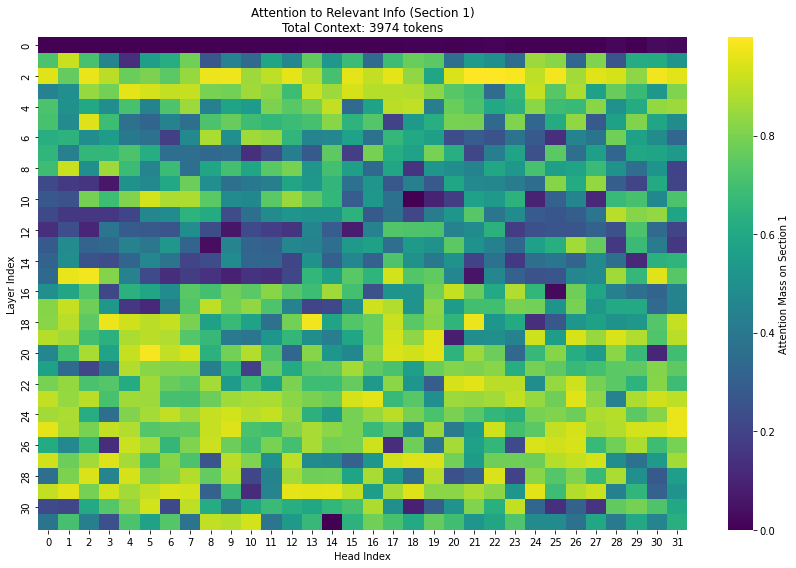

Top Retrieval Head: Layer 2, Head 21 (Attn: 0.9991)

Average Attention to Section 1 by Layer:
Layer 1: 0.5653
Layer 2: 0.8918
Layer 3: 0.7728
Layer 4: 0.6724
Layer 5: 0.6037
Layer 6: 0.4905
Layer 7: 0.4913
Layer 8: 0.5649
Layer 9: 0.4421
Layer 10: 0.5289
Layer 11: 0.4409
Layer 12: 0.3364
Layer 13: 0.4439
Layer 14: 0.3738
Layer 15: 0.4923
Layer 16: 0.6045
Layer 17: 0.6102
Layer 18: 0.7003
Layer 19: 0.6973
Layer 20: 0.7091
Layer 21: 0.6778
Layer 22: 0.7331
Layer 23: 0.8131
Layer 24: 0.7923
Layer 25: 0.8030
Layer 26: 0.7067
Layer 27: 0.7252
Layer 28: 0.6517
Layer 29: 0.7551
Layer 30: 0.5606
Layer 31: 0.5789


In [ ]:
!pip install seaborn
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(
    attn_matrix, 
    cmap="viridis", 
    cbar_kws={'label': 'Attention Mass on Section 1'},
    yticklabels=2 # Label every 2nd layer to save space
)

plt.title(f"Attention to Relevant Info (Section 1)\nTotal Context: {total_tokens} tokens")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.tight_layout()
plt.show()

max_idx = np.unravel_index(np.argmax(attn_matrix, axis=None), attn_matrix.shape)
print(f"Top Retrieval Head: Layer {max_idx[0]}, Head {max_idx[1]} (Attn: {attn_matrix[max_idx]:.4f})")

# Calculate Average Attention per Layer
avg_attn_per_layer = attn_matrix.mean(axis=1)
print("\nAverage Attention to Section 1 by Layer:")
for i, val in enumerate(avg_attn_per_layer):
    if val > 0.05: # Only show significant layers
        print(f"Layer {i}: {val:.4f}")

Tracking L2.H21 with Surgical Patching...
Length 2660: Attention = 0.9995
Length 4012: Attention = 0.9990
Length 6012: Attention = 0.9985
Length 8012: Attention = 0.9971
Length 10012: Attention = 0.0003
Length 12012: Attention = 0.0001
Length 14012: Attention = 0.0004
Length 16012: Attention = 0.0005


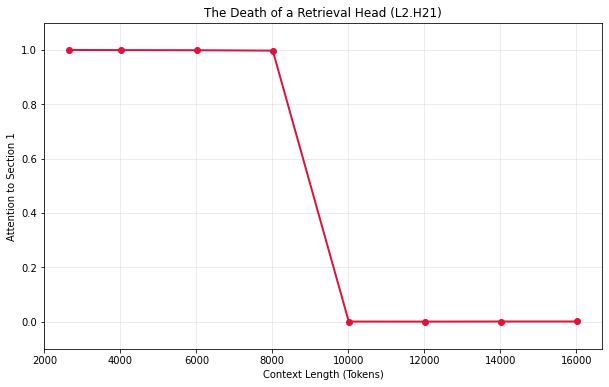

In [17]:
import torch
import gc
import types

# --- CONFIGURATION ---
TARGET_LAYER = 2   
TARGET_HEAD = 21   
# Now we can test even larger contexts without crashing
lengths = [2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000]

# --- THE SURGICAL PROBE ---
def probe_head_surgical(
    model, 
    tokenizer, 
    target_layer_idx, 
    target_head_idx, 
    section_text, 
    distractor_text, 
    total_tokens
):
    # 1. Prepare Prompt (Same as before)
    s1_tokens = tokenizer.encode(f"Section 1: {section_text}", add_special_tokens=False)
    q_tokens = tokenizer.encode("\n\nQuestion: What state is this incorporated in?\nAnswer:", add_special_tokens=False)
    overhead = len(s1_tokens) + len(q_tokens)
    distractor_budget = total_tokens - overhead
    
    if distractor_budget > 0:
        full_alice_tokens = tokenizer.encode(distractor_text, add_special_tokens=False)
        while len(full_alice_tokens) < distractor_budget:
            full_alice_tokens += full_alice_tokens
        alice_str = tokenizer.decode(full_alice_tokens[:distractor_budget])
        full_prompt = (
            f"Section 1: {section_text}\n\n"
            f"[Start Irrelevant Text] {alice_str} [End Irrelevant Text]\n\n"
            "Question: What state is this incorporated in?\nAnswer:"
        )
    else:
        full_prompt = f"Section 1: {section_text}\n\nQuestion: What state is this incorporated in?\nAnswer:"

    # 2. Tokenize
    inputs = tokenizer(full_prompt, return_tensors="pt", add_special_tokens=False).to(model.device)
    input_ids = inputs.input_ids[0]
    
    # 3. Find Indices
    s1_ids = tokenizer.encode(section_text, add_special_tokens=False)
    start_idx, end_idx = 0, 0
    # Search for sequence
    s1_tensor = torch.tensor(s1_ids, device=model.device)
    for i in range(len(input_ids) - len(s1_ids) + 1):
        if torch.equal(input_ids[i : i+len(s1_ids)], s1_tensor):
            start_idx = i
            end_idx = i + len(s1_ids)
            break
    if end_idx == 0: end_idx = 50 # Fallback

    # --- MONKEY PATCH LOGIC ---
    # We will temporarily replace the 'forward' method of ONLY the target layer
    
    # Container for the result
    captured_attn = None
    
    # Get the actual layer object
    target_layer = model.model.layers[target_layer_idx].self_attn
    original_forward = target_layer.forward
    
    # Define the "Spy" forward method
    def spy_forward(self, *args, **kwargs):
        nonlocal captured_attn
        kwargs['output_attentions'] = True
        output = original_forward(*args, **kwargs)
        if output[1] is not None:
            # [0, head, -1, :]
            captured_attn = output[1][0, target_head_idx, -1, :].detach().cpu()
        return (output[0], None, output[2])

    target_layer.forward = types.MethodType(spy_forward, target_layer)

    try:
        with torch.no_grad():
            model(inputs.input_ids, output_attentions=False, use_cache=False)
            
    finally:
        target_layer.forward = original_forward

    if captured_attn is not None:
        score = captured_attn[start_idx:end_idx].sum().item()
        return score, inputs.input_ids.shape[1]
    else:
        return 0.0, 0

# --- RUN LOOP ---
scores = []
final_lengths = []

print(f"Tracking L{TARGET_LAYER}.H{TARGET_HEAD} with Surgical Patching...")

for l in lengths:
    try:
        torch.cuda.empty_cache()
        gc.collect()
        
        score, act_len = probe_head_surgical(
            model, tokenizer, 
            TARGET_LAYER, TARGET_HEAD, 
            section_1_text, alice_text, 
            l
        )
        scores.append(score)
        final_lengths.append(act_len)
        print(f"Length {act_len}: Attention = {score:.4f}")
        
    except Exception as e:
        print(f"Error at length {l}: {e}")
        break

# --- PLOT ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(final_lengths, scores, marker='o', color='crimson', linewidth=2)
plt.title(f"The Death of a Retrieval Head (L{TARGET_LAYER}.H{TARGET_HEAD})")
plt.xlabel("Context Length (Tokens)")
plt.ylabel("Attention to Section 1")
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.show()